In [23]:
import sys
import platform
import src.data.reader as rd
from pathlib import PurePath
from multiprocessing import cpu_count
from src.utils.utils import *

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'
file_name = 'IVE_tickbidask'

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


In [24]:
# Uncomment out to read from a raw data and save to a parquet file
# some code to download from internet goes here
#reader = rd.Reader()
#txt_file_name = file_name + '.txt'
#infp = PurePath(data_raw_dir / txt_file_name)
#df = reader.read_kibot_ticks(infp)

#parq_file_name = file_name+'.parq'
#outfp = PurePath(data_raw_dir / parq_file_name)

# Save file to parquet
#df.to_parquet(outfp)


In [25]:
# Load from parquet
parq_file_name = file_name + '.parq'
infp = PurePath(data_raw_dir / parq_file_name)
df = pd.read_parquet(infp)


In [26]:
import src.features.datacleaner as dc

data_cleaner = dc.DataCleaner()

df = data_cleaner.remove_outliers(df, 'price')
df = df.resample('1T').sum().drop_duplicates().dropna()

cprint(df)


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         price      bid      ask  size     v           dv
dates                                                                    
2019-02-22 15:58:00  1130.4301  1130.38  1130.48  3125  3125  353256.8862
2019-02-22 15:59:00  1017.3950  1017.37  1017.47  1559  1559  176238.3600
2019-02-22 16:00:00   113.0500   113.04   113.05  1147  1147  129668.3500
2019-02-22 16:10:00   113.0500   112.67   113.15     0     0       0.0000
2019-02-22 18:30:00   113.0500   112.57   113.59     0     0       0.0000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 565466 entries, 2009-09-28 09:30:00 to 2019-02-22 18:30:00
Data columns (total 6 columns):
price    565466 non-null float64
bid      565466 non-null float64
ask      565466 non-null float64
size  

Generate dollar bar based features

In [27]:
import src.features.bars as bar
import src.features.labeller as lab

bars = bar.Bars()
dbars = bars.dollar_bar_df(df, 'dv', 10_000).drop_duplicates().dropna()

close = dbars.price.copy()
labeller = lab.Labeller()
dailyVol = labeller.getDailyVol(close).dropna()

cprint(close)

  0%|          | 0/565466 [00:00<?, ?it/s]

 22%|██▏       | 124336/565466 [00:00<00:00, 1243349.33it/s]

 46%|████▌     | 257683/565466 [00:00<00:00, 1269079.50it/s]

 68%|██████▊   | 386659/565466 [00:00<00:00, 1275210.43it/s]

 94%|█████████▍| 532028/565466 [00:00<00:00, 1323976.04it/s]

100%|██████████| 565466/565466 [00:00<00:00, 1346729.62it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                         price
dates                         
2019-02-22 15:56:00   904.2716
2019-02-22 15:57:00   226.0837
2019-02-22 15:58:00  1130.4301
2019-02-22 15:59:00  1017.3950
2019-02-22 16:00:00   113.0500
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521231 entries, 2009-09-28 09:30:00 to 2019-02-22 16:00:00
Data columns (total 1 columns):
price    521231 non-null float64
dtypes: float64(1)
memory usage: 28.0 MB
None
-------------------------------------------------------------------------------



In [28]:
import src.strategy.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7


side = crossover.get_side(close, fast_window, slow_window)

cprint(side)


-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
dates                 
2019-02-22 15:33:00  1
2019-02-22 15:43:00 -1
2019-02-22 15:45:00  1
2019-02-22 15:48:00 -1
2019-02-22 15:54:00  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113378 entries, 2009-09-28 09:36:00 to 2019-02-22 15:54:00
Data columns (total 1 columns):
0    113378 non-null int64
dtypes: int64(1)
memory usage: 1.7 MB
None
-------------------------------------------------------------------------------



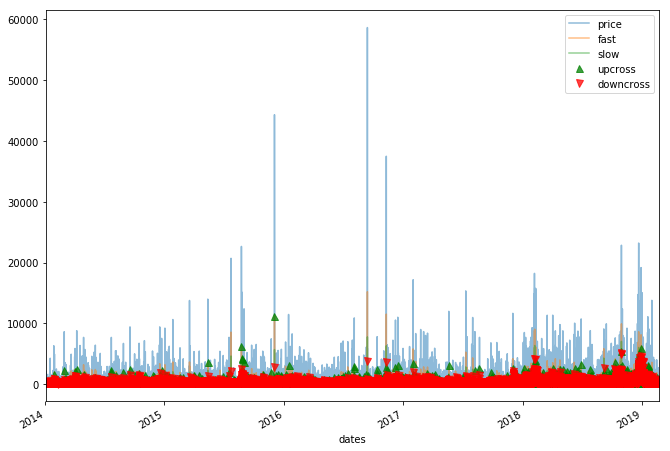

In [29]:
import matplotlib.pyplot as plt

close_df = crossover.close_df(close, fast_window, slow_window)
up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [30]:
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target = dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

minRet = .01 
ptsl=[1, 2]

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)

ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events, close_df['price'], t1).dropna()

Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

data_processed_dir = data_dir / 'processed'
parq_file_name = file_name + 'crossover_train_test.parq'

outfp = PurePath(data_processed_dir / parq_file_name)

Xx.to_parquet(outfp)

  0%|          | 0/521229 [00:00<?, ?it/s]

  0%|          | 284/521229 [00:00<03:03, 2837.43it/s]

  0%|          | 937/521229 [00:00<02:32, 3416.49it/s]

  0%|          | 1596/521229 [00:00<02:10, 3968.95it/s]

  0%|          | 2282/521229 [00:00<01:54, 4542.76it/s]

  1%|          | 3040/521229 [00:00<01:40, 5162.36it/s]

  1%|          | 3824/521229 [00:00<01:29, 5750.82it/s]

  1%|          | 4571/521229 [00:00<01:23, 6175.92it/s]

  1%|          | 5302/521229 [00:00<01:19, 6476.99it/s]

  1%|          | 6086/521229 [00:00<01:15, 6831.86it/s]

  1%|▏         | 6852/521229 [00:01<01:12, 7058.82it/s]

  1%|▏         | 7622/521229 [00:01<01:10, 7239.59it/s]

  2%|▏         | 8405/521229 [00:01<01:09, 7404.65it/s]

  2%|▏         | 9197/521229 [00:01<01:07, 7549.50it/s]

  2%|▏         | 9981/521229 [00:01<01:06, 7633.67it/s]

  2%|▏         | 10756/521229 [00:01<01:06, 7665.84it/s]

  2%|▏         | 11528/521229 [00:01<01:06, 7671.01it/s]

  2%|▏         | 12314/521229 [00:01<01:05, 7726.07it/s]

  3%|▎         | 13090/521229 [00:01<01:05, 7734.15it/s]

  3%|▎         | 13866/521229 [00:01<01:05, 7727.83it/s]

  3%|▎         | 14640/521229 [00:02<01:05, 7710.15it/s]

  3%|▎         | 15416/521229 [00:02<01:05, 7722.71it/s]

  3%|▎         | 16196/521229 [00:02<01:05, 7743.24it/s]

  3%|▎         | 16979/521229 [00:02<01:04, 7768.95it/s]

  3%|▎         | 17766/521229 [00:02<01:04, 7797.60it/s]

  4%|▎         | 18554/521229 [00:02<01:04, 7821.07it/s]

  4%|▎         | 19349/521229 [00:02<01:03, 7857.49it/s]

  4%|▍         | 20135/521229 [00:02<01:04, 7778.06it/s]

  4%|▍         | 20926/521229 [00:02<01:04, 7815.39it/s]

  4%|▍         | 21708/521229 [00:02<01:04, 7793.03it/s]

  4%|▍         | 22488/521229 [00:03<01:04, 7751.66it/s]

  4%|▍         | 23267/521229 [00:03<01:04, 7761.78it/s]

  5%|▍         | 24047/521229 [00:03<01:03, 7770.97it/s]

  5%|▍         | 24825/521229 [00:03<01:04, 7716.50it/s]

  5%|▍         | 25599/521229 [00:03<01:04, 7721.82it/s]

  5%|▌         | 26377/521229 [00:03<01:03, 7738.98it/s]

  5%|▌         | 27155/521229 [00:03<01:03, 7748.46it/s]

  5%|▌         | 27930/521229 [00:03<01:04, 7698.14it/s]

  6%|▌         | 28700/521229 [00:03<01:03, 7696.90it/s]

  6%|▌         | 29483/521229 [00:03<01:03, 7735.11it/s]

  6%|▌         | 30265/521229 [00:04<01:03, 7759.95it/s]

  6%|▌         | 31042/521229 [00:04<01:03, 7705.93it/s]

  6%|▌         | 31813/521229 [00:04<01:03, 7694.67it/s]

  6%|▋         | 32604/521229 [00:04<01:02, 7757.13it/s]

  6%|▋         | 33380/521229 [00:04<01:03, 7733.36it/s]

  7%|▋         | 34154/521229 [00:04<01:03, 7694.72it/s]

  7%|▋         | 34932/521229 [00:04<01:03, 7718.57it/s]

  7%|▋         | 35704/521229 [00:04<01:03, 7670.47it/s]

  7%|▋         | 36478/521229 [00:04<01:03, 7688.93it/s]

  7%|▋         | 37259/521229 [00:04<01:02, 7723.18it/s]

  7%|▋         | 38032/521229 [00:05<01:02, 7720.83it/s]

  7%|▋         | 38809/521229 [00:05<01:02, 7734.62it/s]

  8%|▊         | 39590/521229 [00:05<01:02, 7754.65it/s]

  8%|▊         | 40374/521229 [00:05<01:01, 7779.16it/s]

  8%|▊         | 41152/521229 [00:05<01:01, 7778.27it/s]

  8%|▊         | 41930/521229 [00:05<01:01, 7766.65it/s]

  8%|▊         | 42710/521229 [00:05<01:01, 7776.25it/s]

  8%|▊         | 43488/521229 [00:05<01:01, 7761.31it/s]

  8%|▊         | 44271/521229 [00:05<01:01, 7780.54it/s]

  9%|▊         | 45050/521229 [00:05<01:01, 7774.43it/s]

  9%|▉         | 45828/521229 [00:06<01:01, 7744.45it/s]

  9%|▉         | 46604/521229 [00:06<01:01, 7746.88it/s]

  9%|▉         | 47390/521229 [00:06<01:00, 7777.94it/s]

  9%|▉         | 48178/521229 [00:06<01:00, 7805.86it/s]

  9%|▉         | 48959/521229 [00:06<01:00, 7789.30it/s]

 10%|▉         | 49741/521229 [00:06<01:00, 7796.18it/s]

 10%|▉         | 50522/521229 [00:06<01:00, 7799.52it/s]

 10%|▉         | 51302/521229 [00:06<01:01, 7692.25it/s]

 10%|▉         | 52086/521229 [00:06<01:00, 7735.83it/s]

 10%|█         | 52867/521229 [00:06<01:00, 7757.21it/s]

 10%|█         | 53657/521229 [00:07<00:59, 7798.37it/s]

 10%|█         | 54438/521229 [00:07<00:59, 7780.55it/s]

 11%|█         | 55225/521229 [00:07<00:59, 7806.61it/s]

 11%|█         | 56006/521229 [00:07<00:59, 7765.77it/s]

 11%|█         | 56796/521229 [00:07<00:59, 7802.43it/s]

 11%|█         | 57577/521229 [00:07<00:59, 7802.46it/s]

 11%|█         | 58360/521229 [00:07<00:59, 7808.32it/s]

 11%|█▏        | 59141/521229 [00:07<00:59, 7761.26it/s]

 11%|█▏        | 59918/521229 [00:07<00:59, 7734.65it/s]

 12%|█▏        | 60696/521229 [00:07<00:59, 7745.42it/s]

 12%|█▏        | 61481/521229 [00:08<00:59, 7775.25it/s]

 12%|█▏        | 62277/521229 [00:08<00:58, 7829.35it/s]

 12%|█▏        | 63065/521229 [00:08<00:58, 7841.74it/s]

 12%|█▏        | 63855/521229 [00:08<00:58, 7859.08it/s]

 12%|█▏        | 64641/521229 [00:08<00:58, 7821.65it/s]

 13%|█▎        | 65424/521229 [00:08<00:58, 7819.07it/s]

 13%|█▎        | 66206/521229 [00:08<00:58, 7795.26it/s]

 13%|█▎        | 66986/521229 [00:08<00:58, 7723.08it/s]

 13%|█▎        | 67764/521229 [00:08<00:58, 7737.51it/s]

 13%|█▎        | 68548/521229 [00:08<00:58, 7767.56it/s]

 13%|█▎        | 69330/521229 [00:09<00:58, 7783.15it/s]

 13%|█▎        | 70109/521229 [00:09<00:58, 7720.39it/s]

 14%|█▎        | 70891/521229 [00:09<00:58, 7749.55it/s]

 14%|█▎        | 71667/521229 [00:09<00:58, 7725.47it/s]

 14%|█▍        | 72443/521229 [00:09<00:58, 7734.71it/s]

 14%|█▍        | 73217/521229 [00:09<00:58, 7718.10it/s]

 14%|█▍        | 74008/521229 [00:09<00:57, 7771.90it/s]

 14%|█▍        | 74786/521229 [00:09<00:57, 7728.43it/s]

 14%|█▍        | 75576/521229 [00:09<00:57, 7777.75it/s]

 15%|█▍        | 76356/521229 [00:09<00:57, 7783.90it/s]

 15%|█▍        | 77135/521229 [00:10<00:57, 7724.74it/s]

 15%|█▍        | 77908/521229 [00:10<00:59, 7513.72it/s]

 15%|█▌        | 78665/521229 [00:10<00:58, 7528.00it/s]

 15%|█▌        | 79419/521229 [00:10<00:58, 7526.17it/s]

 15%|█▌        | 80190/521229 [00:10<00:58, 7579.29it/s]

 16%|█▌        | 80975/521229 [00:10<00:57, 7656.23it/s]

 16%|█▌        | 81760/521229 [00:10<00:56, 7712.74it/s]

 16%|█▌        | 82541/521229 [00:10<00:56, 7740.56it/s]

 16%|█▌        | 83316/521229 [00:10<00:56, 7734.97it/s]

 16%|█▌        | 84099/521229 [00:10<00:56, 7760.54it/s]

 16%|█▋        | 84876/521229 [00:11<00:56, 7752.33it/s]

 16%|█▋        | 85652/521229 [00:11<00:56, 7724.11it/s]

 17%|█▋        | 86437/521229 [00:11<00:56, 7755.68it/s]

 17%|█▋        | 87213/521229 [00:11<00:56, 7719.25it/s]

 17%|█▋        | 87986/521229 [00:11<00:56, 7672.55it/s]

 17%|█▋        | 88770/521229 [00:11<00:56, 7719.45it/s]

 17%|█▋        | 89555/521229 [00:11<00:55, 7756.53it/s]

 17%|█▋        | 90331/521229 [00:11<00:55, 7752.54it/s]

 17%|█▋        | 91113/521229 [00:11<00:55, 7771.01it/s]

 18%|█▊        | 91891/521229 [00:11<00:55, 7744.94it/s]

 18%|█▊        | 92666/521229 [00:12<00:55, 7741.93it/s]

 18%|█▊        | 93452/521229 [00:12<00:55, 7776.31it/s]

 18%|█▊        | 94234/521229 [00:12<00:54, 7788.52it/s]

 18%|█▊        | 95016/521229 [00:12<00:54, 7796.89it/s]

 18%|█▊        | 95804/521229 [00:12<00:54, 7821.59it/s]

 19%|█▊        | 96593/521229 [00:12<00:54, 7839.47it/s]

 19%|█▊        | 97377/521229 [00:12<00:54, 7771.30it/s]

 19%|█▉        | 98155/521229 [00:12<00:54, 7751.14it/s]

 19%|█▉        | 98931/521229 [00:12<00:54, 7733.44it/s]

 19%|█▉        | 99706/521229 [00:12<00:54, 7736.81it/s]

 19%|█▉        | 100480/521229 [00:13<00:54, 7731.13it/s]

 19%|█▉        | 101256/521229 [00:13<00:54, 7738.35it/s]

 20%|█▉        | 102030/521229 [00:13<00:54, 7733.42it/s]

 20%|█▉        | 102808/521229 [00:13<00:54, 7747.08it/s]

 20%|█▉        | 103592/521229 [00:13<00:53, 7774.06it/s]

 20%|██        | 104370/521229 [00:13<00:53, 7772.18it/s]

 20%|██        | 105148/521229 [00:13<00:53, 7760.86it/s]

 20%|██        | 105925/521229 [00:13<00:53, 7735.20it/s]

 20%|██        | 106702/521229 [00:13<00:53, 7745.16it/s]

 21%|██        | 107477/521229 [00:13<00:53, 7734.99it/s]

 21%|██        | 108251/521229 [00:14<00:53, 7733.04it/s]

 21%|██        | 109030/521229 [00:14<00:53, 7748.70it/s]

 21%|██        | 109805/521229 [00:14<00:53, 7726.12it/s]

 21%|██        | 110590/521229 [00:14<00:52, 7762.75it/s]

 21%|██▏       | 111376/521229 [00:14<00:52, 7791.31it/s]

 22%|██▏       | 112156/521229 [00:14<00:52, 7776.29it/s]

 22%|██▏       | 112943/521229 [00:14<00:52, 7803.61it/s]

 22%|██▏       | 113732/521229 [00:14<00:52, 7827.21it/s]

 22%|██▏       | 114515/521229 [00:14<00:52, 7801.35it/s]

 22%|██▏       | 115296/521229 [00:14<00:52, 7779.41it/s]

 22%|██▏       | 116074/521229 [00:15<00:52, 7732.25it/s]

 22%|██▏       | 116848/521229 [00:15<00:52, 7727.32it/s]

 23%|██▎       | 117628/521229 [00:15<00:52, 7746.39it/s]

 23%|██▎       | 118403/521229 [00:15<00:51, 7746.69it/s]

 23%|██▎       | 119184/521229 [00:15<00:51, 7765.22it/s]

 23%|██▎       | 119961/521229 [00:15<00:51, 7761.15it/s]

 23%|██▎       | 120745/521229 [00:15<00:51, 7784.12it/s]

 23%|██▎       | 121526/521229 [00:15<00:51, 7790.07it/s]

 23%|██▎       | 122306/521229 [00:15<00:51, 7781.39it/s]

 24%|██▎       | 123087/521229 [00:15<00:51, 7788.02it/s]

 24%|██▍       | 123866/521229 [00:16<00:51, 7781.40it/s]

 24%|██▍       | 124645/521229 [00:16<00:51, 7772.12it/s]

 24%|██▍       | 125424/521229 [00:16<00:50, 7774.75it/s]

 24%|██▍       | 126206/521229 [00:16<00:50, 7785.94it/s]

 24%|██▍       | 126985/521229 [00:16<00:50, 7756.81it/s]

 25%|██▍       | 127761/521229 [00:16<00:50, 7753.51it/s]

 25%|██▍       | 128541/521229 [00:16<00:50, 7764.87it/s]

 25%|██▍       | 129318/521229 [00:16<00:50, 7737.27it/s]

 25%|██▍       | 130103/521229 [00:16<00:50, 7769.09it/s]

 25%|██▌       | 130880/521229 [00:16<00:50, 7756.74it/s]

 25%|██▌       | 131668/521229 [00:17<00:50, 7791.05it/s]

 25%|██▌       | 132448/521229 [00:17<00:50, 7775.58it/s]

 26%|██▌       | 133231/521229 [00:17<00:49, 7790.31it/s]

 26%|██▌       | 134011/521229 [00:17<00:49, 7759.30it/s]

 26%|██▌       | 134787/521229 [00:17<00:49, 7749.61it/s]

 26%|██▌       | 135581/521229 [00:17<00:49, 7805.23it/s]

 26%|██▌       | 136362/521229 [00:17<00:49, 7790.91it/s]

 26%|██▋       | 137144/521229 [00:17<00:49, 7797.56it/s]

 26%|██▋       | 137924/521229 [00:17<00:49, 7786.62it/s]

 27%|██▋       | 138712/521229 [00:18<00:48, 7812.55it/s]

 27%|██▋       | 139494/521229 [00:18<00:49, 7769.11it/s]

 27%|██▋       | 140282/521229 [00:18<00:48, 7801.09it/s]

 27%|██▋       | 141070/521229 [00:18<00:48, 7821.90it/s]

 27%|██▋       | 141853/521229 [00:18<00:48, 7806.91it/s]

 27%|██▋       | 142634/521229 [00:18<00:48, 7781.91it/s]

 28%|██▊       | 143413/521229 [00:18<00:48, 7781.93it/s]

 28%|██▊       | 144192/521229 [00:18<00:48, 7778.41it/s]

 28%|██▊       | 144970/521229 [00:18<00:48, 7740.78it/s]

 28%|██▊       | 145747/521229 [00:18<00:48, 7748.90it/s]

 28%|██▊       | 146522/521229 [00:19<00:48, 7716.83it/s]

 28%|██▊       | 147304/521229 [00:19<00:48, 7746.87it/s]

 28%|██▊       | 148079/521229 [00:19<00:48, 7724.13it/s]

 29%|██▊       | 148862/521229 [00:19<00:48, 7755.57it/s]

 29%|██▊       | 149638/521229 [00:19<00:48, 7602.20it/s]

 29%|██▉       | 150420/521229 [00:19<00:48, 7666.18it/s]

 29%|██▉       | 151203/521229 [00:19<00:47, 7712.46it/s]

 29%|██▉       | 151975/521229 [00:19<00:47, 7712.78it/s]

 29%|██▉       | 152747/521229 [00:19<00:48, 7668.00it/s]

 29%|██▉       | 153530/521229 [00:19<00:47, 7713.25it/s]

 30%|██▉       | 154302/521229 [00:20<00:47, 7699.72it/s]

 30%|██▉       | 155073/521229 [00:20<00:47, 7688.90it/s]

 30%|██▉       | 155846/521229 [00:20<00:47, 7698.96it/s]

 30%|███       | 156617/521229 [00:20<00:47, 7688.49it/s]

 30%|███       | 157398/521229 [00:20<00:47, 7724.44it/s]

 30%|███       | 158183/521229 [00:20<00:46, 7759.86it/s]

 30%|███       | 158961/521229 [00:20<00:46, 7765.66it/s]

 31%|███       | 159738/521229 [00:20<00:46, 7736.70it/s]

 31%|███       | 160515/521229 [00:20<00:46, 7745.86it/s]

 31%|███       | 161292/521229 [00:20<00:46, 7751.80it/s]

 31%|███       | 162073/521229 [00:21<00:46, 7766.51it/s]

 31%|███       | 162850/521229 [00:21<00:46, 7716.43it/s]

 31%|███▏      | 163622/521229 [00:21<00:46, 7693.37it/s]

 32%|███▏      | 164395/521229 [00:21<00:46, 7703.43it/s]

 32%|███▏      | 165167/521229 [00:21<00:46, 7707.07it/s]

 32%|███▏      | 165941/521229 [00:21<00:46, 7714.48it/s]

 32%|███▏      | 166729/521229 [00:21<00:45, 7762.64it/s]

 32%|███▏      | 167506/521229 [00:21<00:45, 7713.19it/s]

 32%|███▏      | 168278/521229 [00:21<00:45, 7692.44it/s]

 32%|███▏      | 169056/521229 [00:21<00:45, 7717.93it/s]

 33%|███▎      | 169843/521229 [00:22<00:45, 7762.47it/s]

 33%|███▎      | 170624/521229 [00:22<00:45, 7775.53it/s]

 33%|███▎      | 171408/521229 [00:22<00:44, 7793.36it/s]

 33%|███▎      | 172191/521229 [00:22<00:44, 7802.85it/s]

 33%|███▎      | 172972/521229 [00:22<00:44, 7799.99it/s]

 33%|███▎      | 173756/521229 [00:22<00:44, 7809.43it/s]

 33%|███▎      | 174537/521229 [00:22<00:44, 7789.39it/s]

 34%|███▎      | 175316/521229 [00:22<00:44, 7765.14it/s]

 34%|███▍      | 176094/521229 [00:22<00:44, 7767.87it/s]

 34%|███▍      | 176871/521229 [00:22<00:44, 7719.90it/s]

 34%|███▍      | 177652/521229 [00:23<00:44, 7744.80it/s]

 34%|███▍      | 178427/521229 [00:23<00:44, 7732.85it/s]

 34%|███▍      | 179201/521229 [00:23<00:44, 7726.10it/s]

 35%|███▍      | 179974/521229 [00:23<00:44, 7712.19it/s]

 35%|███▍      | 180746/521229 [00:23<00:44, 7674.62it/s]

 35%|███▍      | 181517/521229 [00:23<00:44, 7683.45it/s]

 35%|███▍      | 182290/521229 [00:23<00:44, 7694.65it/s]

 35%|███▌      | 183060/521229 [00:23<00:44, 7676.84it/s]

 35%|███▌      | 183830/521229 [00:23<00:43, 7683.37it/s]

 35%|███▌      | 184615/521229 [00:23<00:43, 7730.16it/s]

 36%|███▌      | 185389/521229 [00:24<00:43, 7723.85it/s]

 36%|███▌      | 186172/521229 [00:24<00:43, 7753.41it/s]

 36%|███▌      | 186949/521229 [00:24<00:43, 7755.82it/s]

 36%|███▌      | 187729/521229 [00:24<00:42, 7767.61it/s]

 36%|███▌      | 188509/521229 [00:24<00:42, 7774.99it/s]

 36%|███▋      | 189287/521229 [00:24<00:42, 7754.68it/s]

 36%|███▋      | 190063/521229 [00:24<00:42, 7749.09it/s]

 37%|███▋      | 190838/521229 [00:24<00:42, 7717.28it/s]

 37%|███▋      | 191610/521229 [00:24<00:42, 7701.72it/s]

 37%|███▋      | 192381/521229 [00:24<00:44, 7468.05it/s]

 37%|███▋      | 193153/521229 [00:25<00:43, 7539.72it/s]

 37%|███▋      | 193910/521229 [00:25<00:43, 7547.07it/s]

 37%|███▋      | 194666/521229 [00:25<00:43, 7546.26it/s]

 37%|███▋      | 195445/521229 [00:25<00:42, 7616.22it/s]

 38%|███▊      | 196218/521229 [00:25<00:42, 7649.44it/s]

 38%|███▊      | 197008/521229 [00:25<00:41, 7722.44it/s]

 38%|███▊      | 197785/521229 [00:25<00:41, 7735.43it/s]

 38%|███▊      | 198559/521229 [00:25<00:41, 7684.87it/s]

 38%|███▊      | 199328/521229 [00:25<00:41, 7684.73it/s]

 38%|███▊      | 200097/521229 [00:25<00:41, 7670.26it/s]

 39%|███▊      | 200869/521229 [00:26<00:41, 7682.52it/s]

 39%|███▊      | 201648/521229 [00:26<00:41, 7713.08it/s]

 39%|███▉      | 202434/521229 [00:26<00:41, 7753.77it/s]

 39%|███▉      | 203210/521229 [00:26<00:41, 7654.18it/s]

 39%|███▉      | 203976/521229 [00:26<00:42, 7526.72it/s]

 39%|███▉      | 204755/521229 [00:26<00:41, 7602.55it/s]

 39%|███▉      | 205529/521229 [00:26<00:41, 7641.93it/s]

 40%|███▉      | 206294/521229 [00:26<00:41, 7622.08it/s]

 40%|███▉      | 207078/521229 [00:26<00:40, 7685.32it/s]

 40%|███▉      | 207851/521229 [00:26<00:40, 7698.32it/s]

 40%|████      | 208632/521229 [00:27<00:40, 7731.28it/s]

 40%|████      | 209406/521229 [00:27<00:40, 7719.96it/s]

 40%|████      | 210179/521229 [00:27<00:40, 7677.00it/s]

 40%|████      | 210972/521229 [00:27<00:40, 7750.12it/s]

 41%|████      | 211748/521229 [00:27<00:39, 7748.18it/s]

 41%|████      | 212529/521229 [00:27<00:39, 7766.62it/s]

 41%|████      | 213313/521229 [00:27<00:39, 7788.00it/s]

 41%|████      | 214092/521229 [00:27<00:39, 7740.41it/s]

 41%|████      | 214886/521229 [00:27<00:39, 7798.21it/s]

 41%|████▏     | 215674/521229 [00:27<00:39, 7822.13it/s]

 42%|████▏     | 216470/521229 [00:28<00:38, 7862.63it/s]

 42%|████▏     | 217257/521229 [00:28<00:38, 7842.13it/s]

 42%|████▏     | 218042/521229 [00:28<00:38, 7837.04it/s]

 42%|████▏     | 218831/521229 [00:28<00:38, 7850.65it/s]

 42%|████▏     | 219617/521229 [00:28<00:38, 7802.91it/s]

 42%|████▏     | 220398/521229 [00:28<00:38, 7782.17it/s]

 42%|████▏     | 221178/521229 [00:28<00:38, 7784.67it/s]

 43%|████▎     | 221957/521229 [00:28<00:38, 7770.00it/s]

 43%|████▎     | 222749/521229 [00:28<00:38, 7813.06it/s]

 43%|████▎     | 223531/521229 [00:28<00:38, 7783.60it/s]

 43%|████▎     | 224310/521229 [00:29<00:38, 7776.84it/s]

 43%|████▎     | 225099/521229 [00:29<00:37, 7807.76it/s]

 43%|████▎     | 225880/521229 [00:29<00:37, 7800.31it/s]

 43%|████▎     | 226668/521229 [00:29<00:37, 7823.42it/s]

 44%|████▎     | 227451/521229 [00:29<00:37, 7818.03it/s]

 44%|████▍     | 228233/521229 [00:29<00:37, 7795.94it/s]

 44%|████▍     | 229013/521229 [00:29<00:37, 7732.79it/s]

 44%|████▍     | 229787/521229 [00:29<00:37, 7696.00it/s]

 44%|████▍     | 230563/521229 [00:29<00:37, 7714.26it/s]

 44%|████▍     | 231336/521229 [00:29<00:37, 7718.71it/s]

 45%|████▍     | 232108/521229 [00:30<00:37, 7711.13it/s]

 45%|████▍     | 232880/521229 [00:30<00:37, 7706.42it/s]

 45%|████▍     | 233652/521229 [00:30<00:37, 7708.99it/s]

 45%|████▍     | 234427/521229 [00:30<00:37, 7720.88it/s]

 45%|████▌     | 235200/521229 [00:30<00:37, 7719.49it/s]

 45%|████▌     | 235972/521229 [00:30<00:37, 7693.17it/s]

 45%|████▌     | 236752/521229 [00:30<00:36, 7722.69it/s]

 46%|████▌     | 237525/521229 [00:30<00:36, 7712.17it/s]

 46%|████▌     | 238303/521229 [00:30<00:36, 7732.14it/s]

 46%|████▌     | 239077/521229 [00:30<00:36, 7732.50it/s]

 46%|████▌     | 239857/521229 [00:31<00:36, 7751.51it/s]

 46%|████▌     | 240633/521229 [00:31<00:36, 7727.82it/s]

 46%|████▋     | 241406/521229 [00:31<00:36, 7716.92it/s]

 46%|████▋     | 242178/521229 [00:31<00:36, 7686.54it/s]

 47%|████▋     | 242947/521229 [00:31<00:36, 7561.36it/s]

 47%|████▋     | 243704/521229 [00:31<00:36, 7512.78it/s]

 47%|████▋     | 244456/521229 [00:31<00:36, 7482.51it/s]

 47%|████▋     | 245205/521229 [00:31<00:37, 7418.57it/s]

 47%|████▋     | 245948/521229 [00:31<00:37, 7394.84it/s]

 47%|████▋     | 246715/521229 [00:32<00:36, 7472.80it/s]

 47%|████▋     | 247476/521229 [00:32<00:36, 7513.11it/s]

 48%|████▊     | 248258/521229 [00:32<00:35, 7601.28it/s]

 48%|████▊     | 249033/521229 [00:32<00:35, 7642.65it/s]

 48%|████▊     | 249816/521229 [00:32<00:35, 7697.32it/s]

 48%|████▊     | 250587/521229 [00:32<00:35, 7675.52it/s]

 48%|████▊     | 251364/521229 [00:32<00:35, 7701.95it/s]

 48%|████▊     | 252135/521229 [00:32<00:35, 7685.67it/s]

 49%|████▊     | 252905/521229 [00:32<00:34, 7687.62it/s]

 49%|████▊     | 253687/521229 [00:32<00:34, 7726.63it/s]

 49%|████▉     | 254460/521229 [00:33<00:34, 7723.54it/s]

 49%|████▉     | 255239/521229 [00:33<00:34, 7743.15it/s]

 49%|████▉     | 256018/521229 [00:33<00:34, 7755.34it/s]

 49%|████▉     | 256800/521229 [00:33<00:34, 7772.49it/s]

 49%|████▉     | 257587/521229 [00:33<00:33, 7799.05it/s]

 50%|████▉     | 258375/521229 [00:33<00:33, 7822.21it/s]

 50%|████▉     | 259158/521229 [00:33<00:33, 7805.03it/s]

 50%|████▉     | 259939/521229 [00:33<00:33, 7772.88it/s]

 50%|█████     | 260721/521229 [00:33<00:33, 7786.47it/s]

 50%|█████     | 261503/521229 [00:33<00:33, 7795.66it/s]

 50%|█████     | 262286/521229 [00:34<00:33, 7804.02it/s]

 50%|█████     | 263075/521229 [00:34<00:32, 7827.73it/s]

 51%|█████     | 263858/521229 [00:34<00:32, 7807.76it/s]

 51%|█████     | 264639/521229 [00:34<00:32, 7786.50it/s]

 51%|█████     | 265421/521229 [00:34<00:32, 7795.35it/s]

 51%|█████     | 266201/521229 [00:34<00:32, 7793.78it/s]

 51%|█████     | 266985/521229 [00:34<00:32, 7805.07it/s]

 51%|█████▏    | 267766/521229 [00:34<00:32, 7750.19it/s]

 52%|█████▏    | 268542/521229 [00:34<00:32, 7719.23it/s]

 52%|█████▏    | 269317/521229 [00:34<00:32, 7726.94it/s]

 52%|█████▏    | 270093/521229 [00:35<00:32, 7734.47it/s]

 52%|█████▏    | 270867/521229 [00:35<00:32, 7699.80it/s]

 52%|█████▏    | 271643/521229 [00:35<00:32, 7716.15it/s]

 52%|█████▏    | 272415/521229 [00:35<00:32, 7700.15it/s]

 52%|█████▏    | 273206/521229 [00:35<00:31, 7760.60it/s]

 53%|█████▎    | 273986/521229 [00:35<00:31, 7771.49it/s]

 53%|█████▎    | 274764/521229 [00:35<00:31, 7773.35it/s]

 53%|█████▎    | 275542/521229 [00:35<00:31, 7765.07it/s]

 53%|█████▎    | 276319/521229 [00:35<00:31, 7733.16it/s]

 53%|█████▎    | 277093/521229 [00:35<00:31, 7719.63it/s]

 53%|█████▎    | 277868/521229 [00:36<00:31, 7727.63it/s]

 53%|█████▎    | 278659/521229 [00:36<00:31, 7779.39it/s]

 54%|█████▎    | 279444/521229 [00:36<00:30, 7800.07it/s]

 54%|█████▍    | 280237/521229 [00:36<00:30, 7836.88it/s]

 54%|█████▍    | 281027/521229 [00:36<00:30, 7853.25it/s]

 54%|█████▍    | 281813/521229 [00:36<00:30, 7820.78it/s]

 54%|█████▍    | 282596/521229 [00:36<00:30, 7780.75it/s]

 54%|█████▍    | 283375/521229 [00:36<00:30, 7731.67it/s]

 55%|█████▍    | 284161/521229 [00:36<00:30, 7767.48it/s]

 55%|█████▍    | 284938/521229 [00:36<00:30, 7766.34it/s]

 55%|█████▍    | 285721/521229 [00:37<00:30, 7782.89it/s]

 55%|█████▍    | 286500/521229 [00:37<00:30, 7777.03it/s]

 55%|█████▌    | 287284/521229 [00:37<00:30, 7794.21it/s]

 55%|█████▌    | 288068/521229 [00:37<00:29, 7805.58it/s]

 55%|█████▌    | 288851/521229 [00:37<00:29, 7811.50it/s]

 56%|█████▌    | 289633/521229 [00:37<00:29, 7801.94it/s]

 56%|█████▌    | 290421/521229 [00:37<00:29, 7823.40it/s]

 56%|█████▌    | 291204/521229 [00:37<00:29, 7784.61it/s]

 56%|█████▌    | 291994/521229 [00:37<00:29, 7817.13it/s]

 56%|█████▌    | 292777/521229 [00:37<00:29, 7819.16it/s]

 56%|█████▋    | 293559/521229 [00:38<00:29, 7773.84it/s]

 56%|█████▋    | 294337/521229 [00:38<00:29, 7761.08it/s]

 57%|█████▋    | 295114/521229 [00:38<00:29, 7739.81it/s]

 57%|█████▋    | 295898/521229 [00:38<00:29, 7768.72it/s]

 57%|█████▋    | 296682/521229 [00:38<00:28, 7789.43it/s]

 57%|█████▋    | 297465/521229 [00:38<00:28, 7801.04it/s]

 57%|█████▋    | 298246/521229 [00:38<00:28, 7794.50it/s]

 57%|█████▋    | 299026/521229 [00:38<00:28, 7721.34it/s]

 58%|█████▊    | 299799/521229 [00:38<00:28, 7699.22it/s]

 58%|█████▊    | 300570/521229 [00:38<00:28, 7701.85it/s]

 58%|█████▊    | 301341/521229 [00:39<00:28, 7698.39it/s]

 58%|█████▊    | 302113/521229 [00:39<00:28, 7702.63it/s]

 58%|█████▊    | 302884/521229 [00:39<00:28, 7702.53it/s]

 58%|█████▊    | 303659/521229 [00:39<00:28, 7716.59it/s]

 58%|█████▊    | 304431/521229 [00:39<00:28, 7675.99it/s]

 59%|█████▊    | 305199/521229 [00:39<00:28, 7656.59it/s]

 59%|█████▊    | 305966/521229 [00:39<00:28, 7658.63it/s]

 59%|█████▉    | 306737/521229 [00:39<00:27, 7673.15it/s]

 59%|█████▉    | 307518/521229 [00:39<00:27, 7711.00it/s]

 59%|█████▉    | 308290/521229 [00:39<00:27, 7700.28it/s]

 59%|█████▉    | 309066/521229 [00:40<00:27, 7716.88it/s]

 59%|█████▉    | 309851/521229 [00:40<00:27, 7754.74it/s]

 60%|█████▉    | 310631/521229 [00:40<00:27, 7767.38it/s]

 60%|█████▉    | 311411/521229 [00:40<00:26, 7776.32it/s]

 60%|█████▉    | 312189/521229 [00:40<00:27, 7730.04it/s]

 60%|██████    | 312967/521229 [00:40<00:26, 7742.30it/s]

 60%|██████    | 313750/521229 [00:40<00:26, 7765.79it/s]

 60%|██████    | 314527/521229 [00:40<00:26, 7751.36it/s]

 60%|██████    | 315320/521229 [00:40<00:26, 7803.36it/s]

 61%|██████    | 316101/521229 [00:40<00:26, 7778.53it/s]

 61%|██████    | 316883/521229 [00:41<00:26, 7788.04it/s]

 61%|██████    | 317662/521229 [00:41<00:26, 7773.29it/s]

 61%|██████    | 318440/521229 [00:41<00:26, 7773.09it/s]

 61%|██████    | 319218/521229 [00:41<00:26, 7758.87it/s]

 61%|██████▏   | 319994/521229 [00:41<00:25, 7755.14it/s]

 62%|██████▏   | 320774/521229 [00:41<00:25, 7767.94it/s]

 62%|██████▏   | 321552/521229 [00:41<00:25, 7770.88it/s]

 62%|██████▏   | 322330/521229 [00:41<00:25, 7733.38it/s]

 62%|██████▏   | 323116/521229 [00:41<00:25, 7770.58it/s]

 62%|██████▏   | 323894/521229 [00:41<00:25, 7756.14it/s]

 62%|██████▏   | 324678/521229 [00:42<00:25, 7780.77it/s]

 62%|██████▏   | 325460/521229 [00:42<00:25, 7790.28it/s]

 63%|██████▎   | 326240/521229 [00:42<00:25, 7773.34it/s]

 63%|██████▎   | 327018/521229 [00:42<00:25, 7746.96it/s]

 63%|██████▎   | 327795/521229 [00:42<00:24, 7751.19it/s]

 63%|██████▎   | 328579/521229 [00:42<00:24, 7774.95it/s]

 63%|██████▎   | 329371/521229 [00:42<00:24, 7816.47it/s]

 63%|██████▎   | 330153/521229 [00:42<00:24, 7758.61it/s]

 63%|██████▎   | 330932/521229 [00:42<00:24, 7765.75it/s]

 64%|██████▎   | 331709/521229 [00:42<00:24, 7735.13it/s]

 64%|██████▍   | 332483/521229 [00:43<00:24, 7710.81it/s]

 64%|██████▍   | 333255/521229 [00:43<00:24, 7704.35it/s]

 64%|██████▍   | 334026/521229 [00:43<00:24, 7689.67it/s]

 64%|██████▍   | 334796/521229 [00:43<00:24, 7660.08it/s]

 64%|██████▍   | 335572/521229 [00:43<00:24, 7689.08it/s]

 65%|██████▍   | 336349/521229 [00:43<00:23, 7711.84it/s]

 65%|██████▍   | 337121/521229 [00:43<00:23, 7710.96it/s]

 65%|██████▍   | 337893/521229 [00:43<00:24, 7624.83it/s]

 65%|██████▍   | 338673/521229 [00:43<00:23, 7674.03it/s]

 65%|██████▌   | 339446/521229 [00:43<00:23, 7689.56it/s]

 65%|██████▌   | 340216/521229 [00:44<00:23, 7676.23it/s]

 65%|██████▌   | 340984/521229 [00:44<00:23, 7653.58it/s]

 66%|██████▌   | 341759/521229 [00:44<00:23, 7679.56it/s]

 66%|██████▌   | 342534/521229 [00:44<00:23, 7699.73it/s]

 66%|██████▌   | 343305/521229 [00:44<00:23, 7422.31it/s]

 66%|██████▌   | 344050/521229 [00:44<00:24, 7313.11it/s]

 66%|██████▌   | 344784/521229 [00:44<00:24, 7226.27it/s]

 66%|██████▋   | 345509/521229 [00:44<00:24, 7169.64it/s]

 66%|██████▋   | 346239/521229 [00:44<00:24, 7206.46it/s]

 67%|██████▋   | 346974/521229 [00:44<00:24, 7246.81it/s]

 67%|██████▋   | 347715/521229 [00:45<00:23, 7293.13it/s]

 67%|██████▋   | 348445/521229 [00:45<00:23, 7233.11it/s]

 67%|██████▋   | 349213/521229 [00:45<00:23, 7361.55it/s]

 67%|██████▋   | 349989/521229 [00:45<00:22, 7475.73it/s]

 67%|██████▋   | 350743/521229 [00:45<00:22, 7492.30it/s]

 67%|██████▋   | 351524/521229 [00:45<00:22, 7582.37it/s]

 68%|██████▊   | 352299/521229 [00:45<00:22, 7629.70it/s]

 68%|██████▊   | 353079/521229 [00:45<00:21, 7678.37it/s]

 68%|██████▊   | 353859/521229 [00:45<00:21, 7714.26it/s]

 68%|██████▊   | 354631/521229 [00:45<00:21, 7713.97it/s]

 68%|██████▊   | 355408/521229 [00:46<00:21, 7728.57it/s]

 68%|██████▊   | 356182/521229 [00:46<00:21, 7729.61it/s]

 68%|██████▊   | 356964/521229 [00:46<00:21, 7754.75it/s]

 69%|██████▊   | 357740/521229 [00:46<00:21, 7753.28it/s]

 69%|██████▉   | 358522/521229 [00:46<00:20, 7770.88it/s]

 69%|██████▉   | 359300/521229 [00:46<00:20, 7749.48it/s]

 69%|██████▉   | 360078/521229 [00:46<00:20, 7757.36it/s]

 69%|██████▉   | 360854/521229 [00:46<00:20, 7749.46it/s]

 69%|██████▉   | 361638/521229 [00:46<00:20, 7775.96it/s]

 70%|██████▉   | 362416/521229 [00:47<00:20, 7752.57it/s]

 70%|██████▉   | 363192/521229 [00:47<00:20, 7652.43it/s]

 70%|██████▉   | 363958/521229 [00:47<00:20, 7516.81it/s]

 70%|██████▉   | 364735/521229 [00:47<00:20, 7588.71it/s]

 70%|███████   | 365511/521229 [00:47<00:20, 7637.56it/s]

 70%|███████   | 366280/521229 [00:47<00:20, 7652.48it/s]

 70%|███████   | 367054/521229 [00:47<00:20, 7678.00it/s]

 71%|███████   | 367823/521229 [00:47<00:19, 7679.05it/s]

 71%|███████   | 368592/521229 [00:47<00:19, 7636.42it/s]

 71%|███████   | 369376/521229 [00:47<00:19, 7694.50it/s]

 71%|███████   | 370152/521229 [00:48<00:19, 7712.17it/s]

 71%|███████   | 370937/521229 [00:48<00:19, 7750.23it/s]

 71%|███████▏  | 371713/521229 [00:48<00:19, 7745.64it/s]

 71%|███████▏  | 372488/521229 [00:48<00:19, 7737.40it/s]

 72%|███████▏  | 373270/521229 [00:48<00:19, 7760.52it/s]

 72%|███████▏  | 374047/521229 [00:48<00:19, 7709.63it/s]

 72%|███████▏  | 374819/521229 [00:48<00:19, 7701.24it/s]

 72%|███████▏  | 375590/521229 [00:48<00:18, 7682.69it/s]

 72%|███████▏  | 376364/521229 [00:48<00:18, 7698.36it/s]

 72%|███████▏  | 377145/521229 [00:48<00:18, 7729.08it/s]

 73%|███████▎  | 377929/521229 [00:49<00:18, 7759.54it/s]

 73%|███████▎  | 378706/521229 [00:49<00:18, 7738.60it/s]

 73%|███████▎  | 379480/521229 [00:49<00:18, 7726.02it/s]

 73%|███████▎  | 380264/521229 [00:49<00:18, 7757.26it/s]

 73%|███████▎  | 381040/521229 [00:49<00:18, 7559.45it/s]

 73%|███████▎  | 381798/521229 [00:49<00:18, 7399.04it/s]

 73%|███████▎  | 382557/521229 [00:49<00:18, 7454.04it/s]

 74%|███████▎  | 383314/521229 [00:49<00:18, 7487.81it/s]

 74%|███████▎  | 384064/521229 [00:49<00:18, 7428.18it/s]

 74%|███████▍  | 384830/521229 [00:49<00:18, 7495.22it/s]

 74%|███████▍  | 385610/521229 [00:50<00:17, 7583.32it/s]

 74%|███████▍  | 386382/521229 [00:50<00:17, 7621.54it/s]

 74%|███████▍  | 387145/521229 [00:50<00:17, 7623.29it/s]

 74%|███████▍  | 387933/521229 [00:50<00:17, 7696.57it/s]

 75%|███████▍  | 388704/521229 [00:50<00:17, 7697.09it/s]

 75%|███████▍  | 389478/521229 [00:50<00:17, 7708.62it/s]

 75%|███████▍  | 390271/521229 [00:50<00:16, 7773.08it/s]

 75%|███████▌  | 391049/521229 [00:50<00:16, 7768.94it/s]

 75%|███████▌  | 391827/521229 [00:50<00:16, 7748.82it/s]

 75%|███████▌  | 392603/521229 [00:50<00:16, 7750.89it/s]

 75%|███████▌  | 393392/521229 [00:51<00:16, 7791.84it/s]

 76%|███████▌  | 394176/521229 [00:51<00:16, 7805.38it/s]

 76%|███████▌  | 394957/521229 [00:51<00:16, 7783.03it/s]

 76%|███████▌  | 395736/521229 [00:51<00:16, 7737.61it/s]

 76%|███████▌  | 396516/521229 [00:51<00:16, 7754.93it/s]

 76%|███████▌  | 397292/521229 [00:51<00:16, 7732.47it/s]

 76%|███████▋  | 398075/521229 [00:51<00:15, 7760.59it/s]

 77%|███████▋  | 398852/521229 [00:51<00:15, 7720.86it/s]

 77%|███████▋  | 399631/521229 [00:51<00:15, 7739.83it/s]

 77%|███████▋  | 400406/521229 [00:51<00:15, 7736.24it/s]

 77%|███████▋  | 401184/521229 [00:52<00:15, 7747.98it/s]

 77%|███████▋  | 401959/521229 [00:52<00:15, 7747.96it/s]

 77%|███████▋  | 402737/521229 [00:52<00:15, 7756.03it/s]

 77%|███████▋  | 403513/521229 [00:52<00:15, 7753.89it/s]

 78%|███████▊  | 404301/521229 [00:52<00:15, 7788.67it/s]

 78%|███████▊  | 405080/521229 [00:52<00:14, 7767.02it/s]

 78%|███████▊  | 405869/521229 [00:52<00:14, 7802.21it/s]

 78%|███████▊  | 406650/521229 [00:52<00:14, 7724.01it/s]

 78%|███████▊  | 407427/521229 [00:52<00:14, 7737.25it/s]

 78%|███████▊  | 408202/521229 [00:52<00:14, 7739.59it/s]

 78%|███████▊  | 408979/521229 [00:53<00:14, 7747.04it/s]

 79%|███████▊  | 409764/521229 [00:53<00:14, 7776.84it/s]

 79%|███████▉  | 410542/521229 [00:53<00:14, 7742.28it/s]

 79%|███████▉  | 411322/521229 [00:53<00:14, 7759.27it/s]

 79%|███████▉  | 412099/521229 [00:53<00:14, 7726.59it/s]

 79%|███████▉  | 412887/521229 [00:53<00:13, 7771.91it/s]

 79%|███████▉  | 413667/521229 [00:53<00:13, 7780.11it/s]

 80%|███████▉  | 414446/521229 [00:53<00:13, 7755.46it/s]

 80%|███████▉  | 415222/521229 [00:53<00:13, 7732.01it/s]

 80%|███████▉  | 416005/521229 [00:53<00:13, 7760.57it/s]

 80%|███████▉  | 416782/521229 [00:54<00:13, 7752.80it/s]

 80%|████████  | 417558/521229 [00:54<00:13, 7754.54it/s]

 80%|████████  | 418334/521229 [00:54<00:13, 7754.15it/s]

 80%|████████  | 419118/521229 [00:54<00:13, 7777.41it/s]

 81%|████████  | 419896/521229 [00:54<00:13, 7770.01it/s]

 81%|████████  | 420674/521229 [00:54<00:13, 7690.99it/s]

 81%|████████  | 421444/521229 [00:54<00:12, 7680.27it/s]

 81%|████████  | 422217/521229 [00:54<00:12, 7693.72it/s]

 81%|████████  | 422987/521229 [00:54<00:12, 7677.55it/s]

 81%|████████▏ | 423768/521229 [00:54<00:12, 7715.21it/s]

 81%|████████▏ | 424540/521229 [00:55<00:12, 7682.69it/s]

 82%|████████▏ | 425309/521229 [00:55<00:12, 7662.46it/s]

 82%|████████▏ | 426076/521229 [00:55<00:12, 7629.56it/s]

 82%|████████▏ | 426840/521229 [00:55<00:12, 7628.32it/s]

 82%|████████▏ | 427603/521229 [00:55<00:12, 7627.09it/s]

 82%|████████▏ | 428376/521229 [00:55<00:12, 7657.58it/s]

 82%|████████▏ | 429150/521229 [00:55<00:11, 7680.82it/s]

 82%|████████▏ | 429934/521229 [00:55<00:11, 7727.67it/s]

 83%|████████▎ | 430718/521229 [00:55<00:11, 7760.58it/s]

 83%|████████▎ | 431495/521229 [00:55<00:11, 7740.62it/s]

 83%|████████▎ | 432270/521229 [00:56<00:11, 7725.12it/s]

 83%|████████▎ | 433050/521229 [00:56<00:11, 7745.59it/s]

 83%|████████▎ | 433825/521229 [00:56<00:11, 7740.58it/s]

 83%|████████▎ | 434609/521229 [00:56<00:11, 7768.78it/s]

 84%|████████▎ | 435386/521229 [00:56<00:11, 7759.36it/s]

 84%|████████▎ | 436165/521229 [00:56<00:10, 7766.32it/s]

 84%|████████▍ | 436942/521229 [00:56<00:10, 7724.04it/s]

 84%|████████▍ | 437715/521229 [00:56<00:10, 7702.01it/s]

 84%|████████▍ | 438486/521229 [00:56<00:10, 7692.07it/s]

 84%|████████▍ | 439269/521229 [00:56<00:10, 7730.74it/s]

 84%|████████▍ | 440050/521229 [00:57<00:10, 7752.17it/s]

 85%|████████▍ | 440830/521229 [00:57<00:10, 7766.20it/s]

 85%|████████▍ | 441607/521229 [00:57<00:10, 7762.66it/s]

 85%|████████▍ | 442384/521229 [00:57<00:10, 7570.46it/s]

 85%|████████▌ | 443143/521229 [00:57<00:10, 7426.89it/s]

 85%|████████▌ | 443888/521229 [00:57<00:10, 7340.79it/s]

 85%|████████▌ | 444645/521229 [00:57<00:10, 7407.00it/s]

 85%|████████▌ | 445387/521229 [00:57<00:10, 7185.73it/s]

 86%|████████▌ | 446108/521229 [00:57<00:10, 7136.05it/s]

 86%|████████▌ | 446825/521229 [00:58<00:10, 7141.38it/s]

 86%|████████▌ | 447541/521229 [00:58<00:10, 7047.41it/s]

 86%|████████▌ | 448247/521229 [00:58<00:10, 7040.80it/s]

 86%|████████▌ | 448952/521229 [00:58<00:10, 7043.24it/s]

 86%|████████▋ | 449703/521229 [00:58<00:09, 7175.27it/s]

 86%|████████▋ | 450422/521229 [00:58<00:09, 7138.47it/s]

 87%|████████▋ | 451175/521229 [00:58<00:09, 7250.69it/s]

 87%|████████▋ | 451922/521229 [00:58<00:09, 7314.92it/s]

 87%|████████▋ | 452665/521229 [00:58<00:09, 7347.76it/s]

 87%|████████▋ | 453401/521229 [00:58<00:09, 7265.02it/s]

 87%|████████▋ | 454166/521229 [00:59<00:09, 7374.36it/s]

 87%|████████▋ | 454923/521229 [00:59<00:08, 7430.61it/s]

 87%|████████▋ | 455667/521229 [00:59<00:08, 7340.81it/s]

 88%|████████▊ | 456402/521229 [00:59<00:08, 7228.90it/s]

 88%|████████▊ | 457165/521229 [00:59<00:08, 7344.31it/s]

 88%|████████▊ | 457907/521229 [00:59<00:08, 7365.62it/s]

 88%|████████▊ | 458645/521229 [00:59<00:08, 7234.94it/s]

 88%|████████▊ | 459397/521229 [00:59<00:08, 7315.71it/s]

 88%|████████▊ | 460157/521229 [00:59<00:08, 7398.24it/s]

 88%|████████▊ | 460898/521229 [00:59<00:08, 7281.70it/s]

 89%|████████▊ | 461636/521229 [01:00<00:08, 7308.83it/s]

 89%|████████▊ | 462398/521229 [01:00<00:07, 7398.06it/s]

 89%|████████▉ | 463146/521229 [01:00<00:07, 7420.20it/s]

 89%|████████▉ | 463913/521229 [01:00<00:07, 7492.03it/s]

 89%|████████▉ | 464676/521229 [01:00<00:07, 7530.46it/s]

 89%|████████▉ | 465430/521229 [01:00<00:07, 7376.06it/s]

 89%|████████▉ | 466169/521229 [01:00<00:07, 7243.97it/s]

 90%|████████▉ | 466895/521229 [01:00<00:07, 7170.44it/s]

 90%|████████▉ | 467614/521229 [01:00<00:07, 7173.39it/s]

 90%|████████▉ | 468333/521229 [01:00<00:07, 7168.34it/s]

 90%|████████▉ | 469051/521229 [01:01<00:07, 7065.36it/s]

 90%|█████████ | 469759/521229 [01:01<00:07, 7032.97it/s]

 90%|█████████ | 470497/521229 [01:01<00:07, 7132.90it/s]

 90%|█████████ | 471211/521229 [01:01<00:07, 7123.24it/s]

 91%|█████████ | 471924/521229 [01:01<00:06, 7082.25it/s]

 91%|█████████ | 472635/521229 [01:01<00:06, 7090.25it/s]

 91%|█████████ | 473416/521229 [01:01<00:06, 7289.56it/s]

 91%|█████████ | 474150/521229 [01:01<00:06, 7302.79it/s]

 91%|█████████ | 474929/521229 [01:01<00:06, 7441.35it/s]

 91%|█████████▏| 475704/521229 [01:01<00:06, 7528.93it/s]

 91%|█████████▏| 476483/521229 [01:02<00:05, 7603.44it/s]

 92%|█████████▏| 477245/521229 [01:02<00:05, 7596.68it/s]

 92%|█████████▏| 478006/521229 [01:02<00:05, 7588.37it/s]

 92%|█████████▏| 478766/521229 [01:02<00:05, 7510.03it/s]

 92%|█████████▏| 479529/521229 [01:02<00:05, 7543.68it/s]

 92%|█████████▏| 480284/521229 [01:02<00:05, 7527.54it/s]

 92%|█████████▏| 481038/521229 [01:02<00:05, 7513.96it/s]

 92%|█████████▏| 481790/521229 [01:02<00:05, 7415.42it/s]

 93%|█████████▎| 482556/521229 [01:02<00:05, 7484.97it/s]

 93%|█████████▎| 483305/521229 [01:02<00:05, 7320.14it/s]

 93%|█████████▎| 484039/521229 [01:03<00:05, 6940.77it/s]

 93%|█████████▎| 484738/521229 [01:03<00:05, 6887.44it/s]

 93%|█████████▎| 485431/521229 [01:03<00:05, 6809.47it/s]

 93%|█████████▎| 486125/521229 [01:03<00:05, 6846.59it/s]

 93%|█████████▎| 486844/521229 [01:03<00:04, 6943.57it/s]

 94%|█████████▎| 487544/521229 [01:03<00:04, 6959.03it/s]

 94%|█████████▎| 488242/521229 [01:03<00:04, 6884.98it/s]

 94%|█████████▍| 488995/521229 [01:03<00:04, 7064.93it/s]

 94%|█████████▍| 489744/521229 [01:03<00:04, 7187.03it/s]

 94%|█████████▍| 490513/521229 [01:04<00:04, 7330.67it/s]

 94%|█████████▍| 491270/521229 [01:04<00:04, 7398.32it/s]

 94%|█████████▍| 492043/521229 [01:04<00:03, 7492.62it/s]

 95%|█████████▍| 492809/521229 [01:04<00:03, 7540.59it/s]

 95%|█████████▍| 493579/521229 [01:04<00:03, 7585.68it/s]

 95%|█████████▍| 494348/521229 [01:04<00:03, 7616.47it/s]

 95%|█████████▍| 495121/521229 [01:04<00:03, 7649.06it/s]

 95%|█████████▌| 495887/521229 [01:04<00:03, 7604.77it/s]

 95%|█████████▌| 496663/521229 [01:04<00:03, 7648.70it/s]

 95%|█████████▌| 497429/521229 [01:04<00:03, 7648.87it/s]

 96%|█████████▌| 498204/521229 [01:05<00:02, 7678.91it/s]

 96%|█████████▌| 498973/521229 [01:05<00:02, 7627.58it/s]

 96%|█████████▌| 499736/521229 [01:05<00:02, 7549.30it/s]

 96%|█████████▌| 500492/521229 [01:05<00:02, 7515.76it/s]

 96%|█████████▌| 501255/521229 [01:05<00:02, 7547.03it/s]

 96%|█████████▋| 502010/521229 [01:05<00:02, 7543.03it/s]

 96%|█████████▋| 502765/521229 [01:05<00:02, 7541.17it/s]

 97%|█████████▋| 503520/521229 [01:05<00:02, 7406.81it/s]

 97%|█████████▋| 504296/521229 [01:05<00:02, 7506.79it/s]

 97%|█████████▋| 505062/521229 [01:05<00:02, 7551.35it/s]

 97%|█████████▋| 505834/521229 [01:06<00:02, 7600.22it/s]

 97%|█████████▋| 506595/521229 [01:06<00:01, 7487.99it/s]

 97%|█████████▋| 507359/521229 [01:06<00:01, 7530.57it/s]

 97%|█████████▋| 508142/521229 [01:06<00:01, 7616.01it/s]

 98%|█████████▊| 508905/521229 [01:06<00:01, 7604.26it/s]

 98%|█████████▊| 509687/521229 [01:06<00:01, 7667.70it/s]

 98%|█████████▊| 510457/521229 [01:06<00:01, 7675.52it/s]

 98%|█████████▊| 511232/521229 [01:06<00:01, 7697.31it/s]

 98%|█████████▊| 512009/521229 [01:06<00:01, 7717.93it/s]

 98%|█████████▊| 512788/521229 [01:06<00:01, 7736.95it/s]

 99%|█████████▊| 513564/521229 [01:07<00:00, 7742.29it/s]

 99%|█████████▊| 514339/521229 [01:07<00:00, 7690.08it/s]

 99%|█████████▉| 515113/521229 [01:07<00:00, 7703.68it/s]

 99%|█████████▉| 515886/521229 [01:07<00:00, 7709.64it/s]

 99%|█████████▉| 516658/521229 [01:07<00:00, 7697.40it/s]

 99%|█████████▉| 517428/521229 [01:07<00:00, 7697.51it/s]

 99%|█████████▉| 518212/521229 [01:07<00:00, 7738.32it/s]

100%|█████████▉| 518992/521229 [01:07<00:00, 7755.79it/s]

100%|█████████▉| 519770/521229 [01:07<00:00, 7762.94it/s]

100%|█████████▉| 520547/521229 [01:07<00:00, 7735.42it/s]

100%|██████████| 521229/521229 [01:08<00:00, 7660.99it/s]

2019-03-21 20:21:48.683269 100.0% applyPtSlOnT1 done after 0.67 minutes. Remaining 0.0 minutes.


In [31]:
ma_events.side.value_counts()


 1.0    6833
-1.0    2405
Name: side, dtype: int64

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      3689
         1.0       0.00      0.00      0.00       930

   micro avg       0.80      0.80      0.80      4619
   macro avg       0.40      0.50      0.44      4619
weighted avg       0.64      0.80      0.71      4619



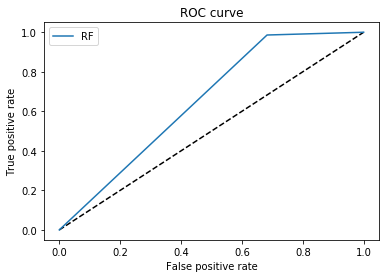

In [32]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from src.utils.utils import get_relative_project_dir, cprint


RANDOM_STATE = 777
#training data
X = Xx.side.values.reshape(-1,1)
#labels
y = Xx.bin.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)

rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


